### Task 2: Non Linear Dataset

#### Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

#### Loading datasets

In [17]:
# Read the dataset while skipping the first line (meta-information)
df = pd.read_csv("../Datasets/NonLinearDataset/NonLinearDataset.txt", sep=" ", header=None, skiprows=1)
df = df.iloc[:, :2]  # Select only the first two columns (features)

# Convert all values to numeric, coercing errors to NaN
df = df.apply(pd.to_numeric, errors='coerce')

#### Dividing training and testing data

In [18]:
# Assign class labels based on the dataset structure
# The first 500 examples belong to class 1, the next 500 to class 2, and the remaining 1000 to class 3
df['class'] = np.concatenate([np.zeros(500), np.ones(500), np.full(1000, 2)])

# Split the data into features (X) and labels (y)
X = df.iloc[:, :2].values  # First two columns as features
y = df['class'].values    # 'class' column as the target labels

# Cast y to integer type to ensure correct processing
y = y.astype(int)

# Split into train and test data (70% training, 30% testing) based on the given order
train_size = int(0.7 * len(df))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Now we have the training and testing data, with three classes
print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Class Distribution in Training Data:", np.bincount(y_train))
print("Class Distribution in Testing Data:", np.bincount(y_test))

# Ensure all classes are represented in the train and test sets
train_data_list = [X_train[y_train == i] for i in range(3)]
test_data_list = [X_test[y_test == i] for i in range(3)]

Training Data Shape: (1400, 2)
Testing Data Shape: (600, 2)
Class Distribution in Training Data: [500 500 400]
Class Distribution in Testing Data: [  0   0 600]


#### KNN model

Classification Report for k=1:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         0
     Class 1       1.00      1.00      1.00         0
     Class 2       1.00      1.00      1.00       600

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Classification Report for k=3:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         0
     Class 1       1.00      1.00      1.00         0
     Class 2       1.00      1.00      1.00       600

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Classification Report for k=5:
              precision    recall  f1-score   support

     Class 0       0.00      1.00      0.00         0
     Class 1       1.00      1.00   

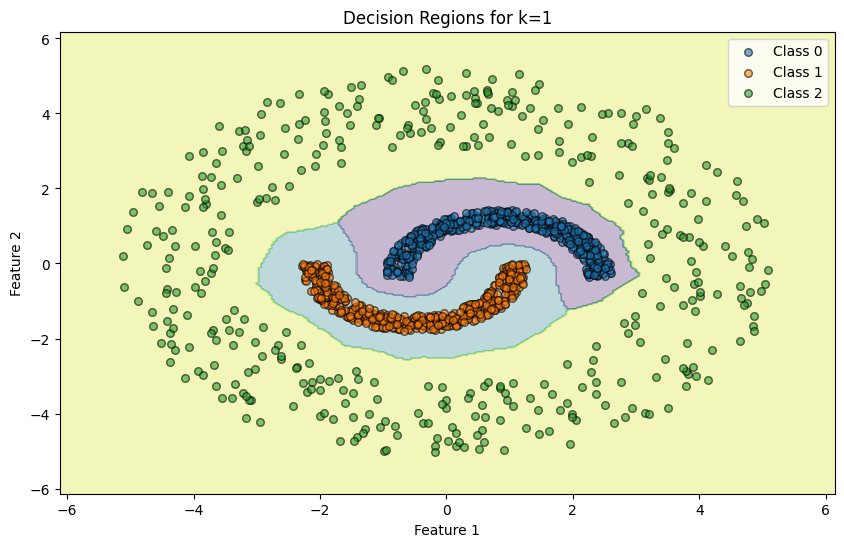

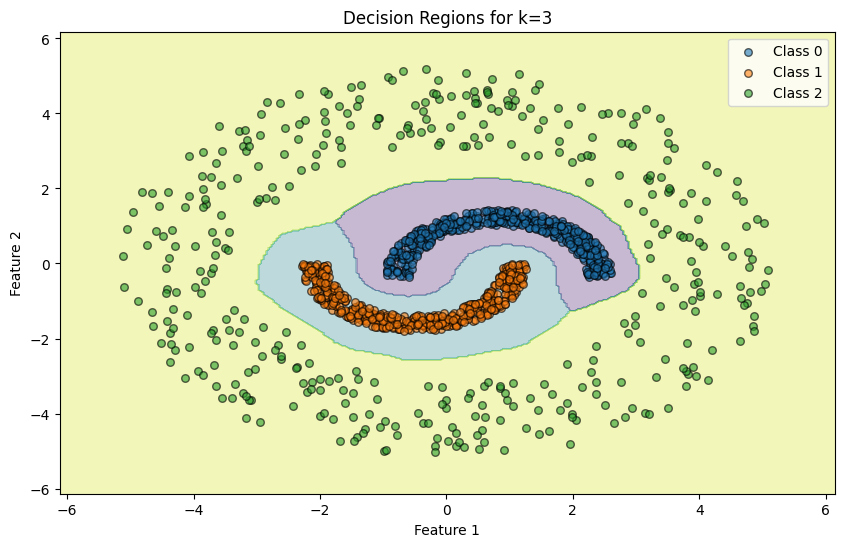

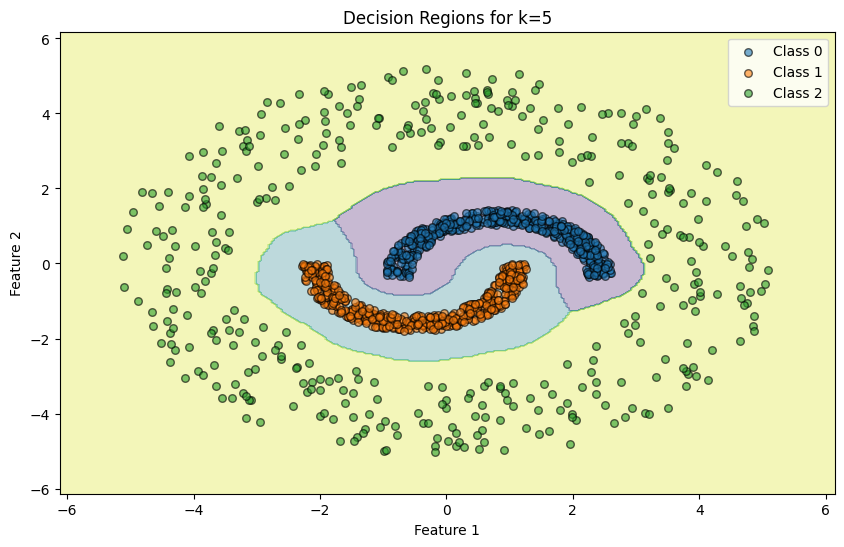

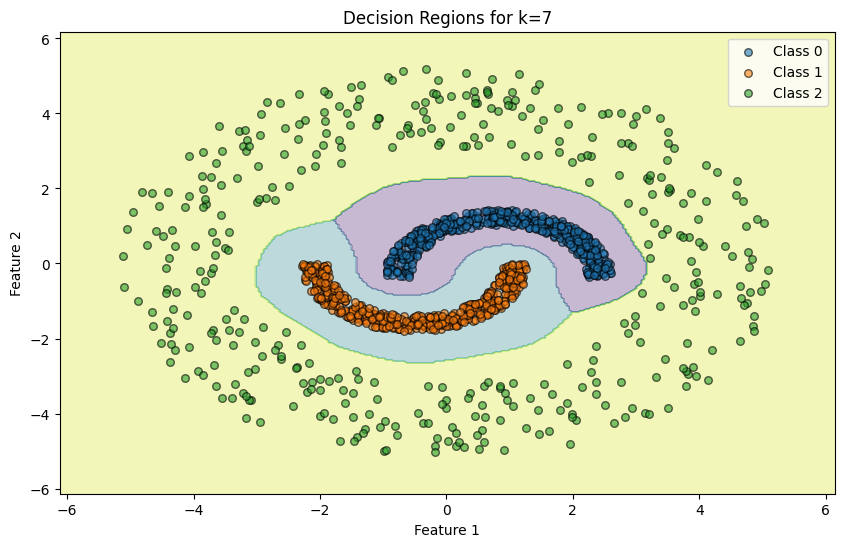

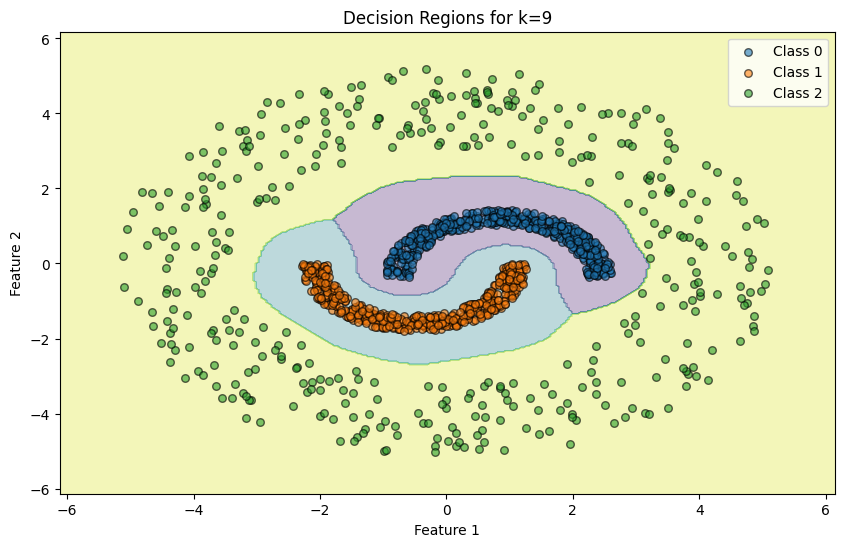

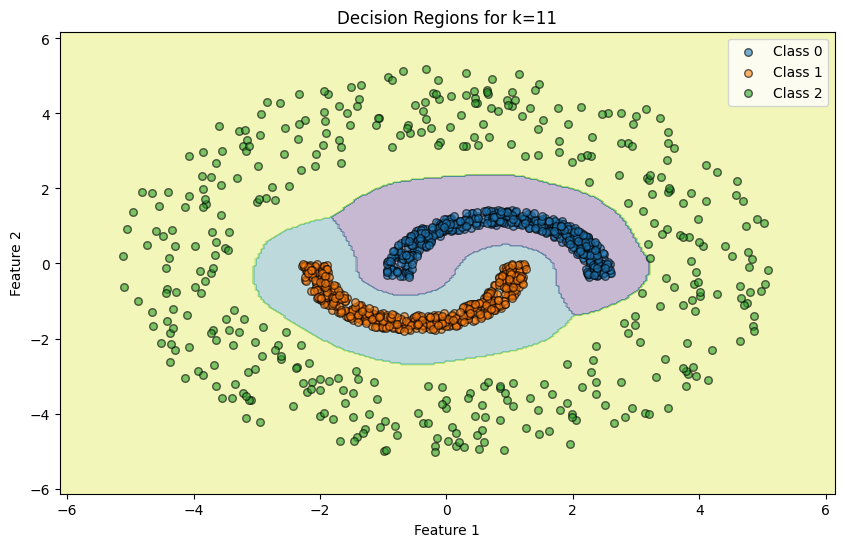

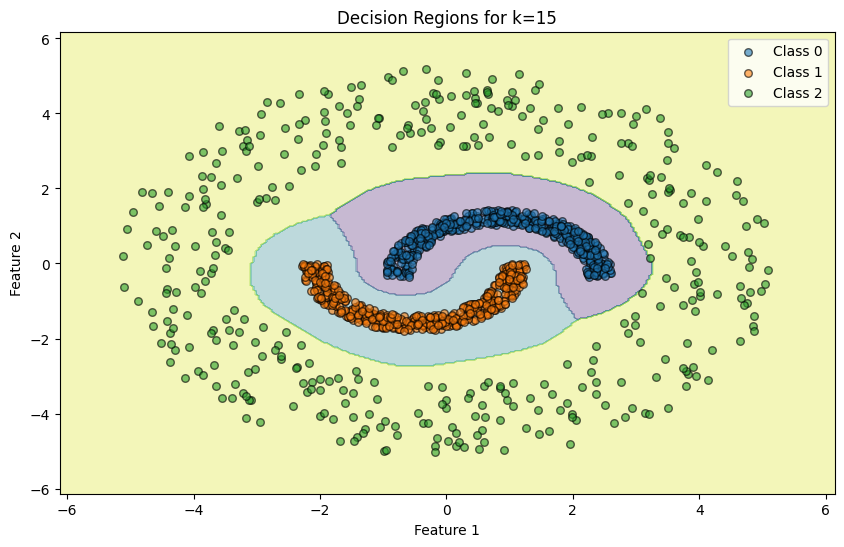

In [20]:
# Define function for KNN Density Estimation
def knn_density_estimation(train_data, test_point, k):
    """
    Estimate the density of a test point using k-nearest neighbors.
    """
    distances = np.linalg.norm(train_data - test_point, axis=1)
    sorted_distances = np.sort(distances)
    return 1 / np.sum(sorted_distances[:k])

# Function to generate classification reports using KNN with Bayes
def bayes_classifier_knn(train_data_list, test_data_list, k_values):
    """
    Classify test data using Bayes classifier with KNN density estimation.
    """
    # Calculate priors for each class
    priors = [len(train_data) / sum(len(df) for df in train_data_list) for train_data in train_data_list]
    results = {}

    # Iterate over different k values
    for k in k_values:
        predictions = []
        true_labels = []

        # Perform prediction on the test set for each class
        for test_class_idx, test_data in enumerate(test_data_list):
            true_labels.extend([test_class_idx] * len(test_data))
            for test_point in test_data:
                posteriors = []
                for class_idx, train_data in enumerate(train_data_list):
                    likelihood = knn_density_estimation(train_data, test_point, k)
                    posteriors.append(likelihood * priors[class_idx])
                predictions.append(np.argmax(posteriors))

        # Convert to numpy arrays
        true_labels = np.array(true_labels)
        predictions = np.array(predictions)

        # Generate classification report
        report = classification_report(true_labels, predictions, labels=[0, 1, 2], target_names=["Class 0", "Class 1", "Class 2"], zero_division=1)
        results[k] = {
            'report': report,
            'true_labels': true_labels,
            'predictions': predictions
        }
        print(f"Classification Report for k={k}:\n{report}")

    return results

# Prepare training and testing data split by classes
train_data_list = [X_train[y_train == i] for i in range(3)]
test_data_list = [X_test[y_test == i] for i in range(3)]

# Define different k values to test
k_values = [1, 3, 5, 7, 9, 11, 15]  # Experiment with a range of k values

# Run the Bayes classifier with KNN density estimation
results = bayes_classifier_knn(train_data_list, test_data_list, k_values)

# Plot decision regions for each k value
def plot_decision_regions(train_data_list, results, k):
    """
    Visualize the decision regions for each k-value of the classifier.
    """
    plt.figure(figsize=(10, 6))
    
    # Define limits for the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    
    Z = np.array([np.argmax([
        knn_density_estimation(train_data, point, k)
        for train_data in train_data_list]) for point in zip(xx.ravel(), yy.ravel())])
    
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3)
    
    # Plot the training data points
    for i, class_data in enumerate(train_data_list):
        plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {i}', s=30, edgecolors='k', alpha=0.6)

    plt.title(f"Decision Regions for k={k}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend(loc="best")
    plt.show()

# Plot decision regions for each k
for k in k_values:
    plot_decision_regions(train_data_list, results, k)
